In [1]:
import pandas as pds
import numpy as np
import os
import tqdm
import glob
import plotly_express as px
import seaborn as sns

In [2]:
bank_lookup = {852218: 'JPMC',
               480228: 'BAC',
               451965: 'Wells',
               476810: 'Citi',
               75633: 'BMO',
               723112: 'FifthThird',
               504713: 'USBank',
               817824: 'PNC',
               112837: 'CapOne',
               497404: 'TD',
               541101: 'BNY',
               35301: 'StateStreet',
               852320: 'BBT',
               675332: 'SunTrust',
               2182786: 'Goldman',
               1456501: 'MS',
               280110: 'Key',
               212465: 'MUFG',
               3303298: 'Citizens',
               233031: 'Regions',
               1394676: 'AMEX',
               30810: 'Discover',
               12311: 'Huntington',
               60143: 'Comerica'}

rssd_list = [bank for bank in bank_lookup]
peer_list = [723112, 12311, 280110, 233031, 3303298, 675332, 817824, 60143]
client_list = [75633]
nonpeer_list = [x for x in rssd_list if x not in peer_list+client_list]

headers_mixA = ['rprt_period','RSSD','UBPR1795','UBPR3123','UBPR4635','UBPRC233',
                'UBPRD582','UBPRE006','UBPRE019','UBPRE020','UBPRE021','UBPRE022','UBPRE023','UBPRE386',
                'UBPRE388','UBPRE390','UBPRE391','UBPRE395','UBPRE397','UBPRE398','UBPRE399','UBPRE400','UBPRE401',
                'UBPRE402','UBPRE404','UBPRE405','UBPRE406','UBPRE407','UBPRE408','UBPRE409','UBPRE410','UBPRE411',
                'UBPRE412','UBPRE413','UBPRE543','UBPRE586','UBPRE587','UBPRE594','UBPRFB60','UBPRFB61','UBPRFB64',
                'UBPRFB66','UBPRFB69','UBPRFB70', 'placeholder']

ratio_lookup_mixA = {'UBPR3123': 'alll',
                    'UBPR1795': 'ncl',
                    'UBPRE386': 'avg_os',
                    'UBPRE019': 'ncl_rate',
                    'UBPRE022': 'alll_rate',
                    'UBPRE021': 'alll_to_ncl',
                    'UBPRE395': 'alll_to_nonaccrual'}

ratio_mixA = ['rprt_period', 'RSSD', 'bank']+[ratio for ratio in ratio_lookup_mixA]+['type']

peer_lookup = {}

dt_list = [str(2005+x) for x in range (14)]

In [3]:
filename = 'ubpr_mixA.csv'

counter = 0
with open(filename, 'w',encoding='utf-8',newline="") as file:
    for dt in dt_list:
        ubpr_files = str(os.getcwd())+"/call_reports/FFIEC CDR Bulk All UBPR Ratios "+dt+ \
                    "/FFIEC CDR UBPR Ratios Allowance and Loan Mix-a "+dt+".txt"

        alll_mixA = pds.read_csv(ubpr_files, sep='\t', skipinitialspace=True, header = None, skiprows = 2)

        alll_mixA.columns = headers_mixA
        alll_mixA = alll_mixA[alll_mixA.RSSD.isin(rssd_list)]
        alll_mixA['bank'] = alll_mixA['RSSD'].map(bank_lookup)
        
        type_cond = [alll_mixA['RSSD'].isin(client_list), alll_mixA['RSSD'].isin(peer_list), alll_mixA['RSSD'].isin(nonpeer_list)]
        type_choise = ['BMO', 'Peers', 'Non-Peers']
        alll_mixA['type'] = np.select(type_cond, type_choise, default = 'Non')

        alll_mixA = alll_mixA.filter(items = ratio_mixA)
        alll_mixA.rename(columns = ratio_lookup_mixA, inplace = True)
        alll_mixA['rprt_period'] = pds.to_datetime(alll_mixA['rprt_period'])
        alll_mixA['rprt_period'] = pds.DatetimeIndex(alll_mixA.rprt_period).normalize()

        if counter == 0:
            alll_mixA.to_csv(file, mode='a', header=True, index=False)
            alll_mixA_agg = alll_mixA
        else:
            alll_mixA.to_csv(file, mode='a', header=False, index=False)
            alll_mixA_agg = alll_mixA_agg.append(alll_mixA)
        counter += 1       
        
alll_mixA_agg.sort_values(by = ['bank', 'rprt_period']).set_index(np.arange(len(alll_mixA_agg)))

alll_mixA_agg['Report_Date'] = pds.DatetimeIndex(alll_mixA_agg['rprt_period']).year.astype(str)+'Q' \
    +pds.DatetimeIndex(alll_mixA_agg['rprt_period']).quarter.astype(str)

alll_mixA_agg.to_csv('alll_mixA_agg.csv')

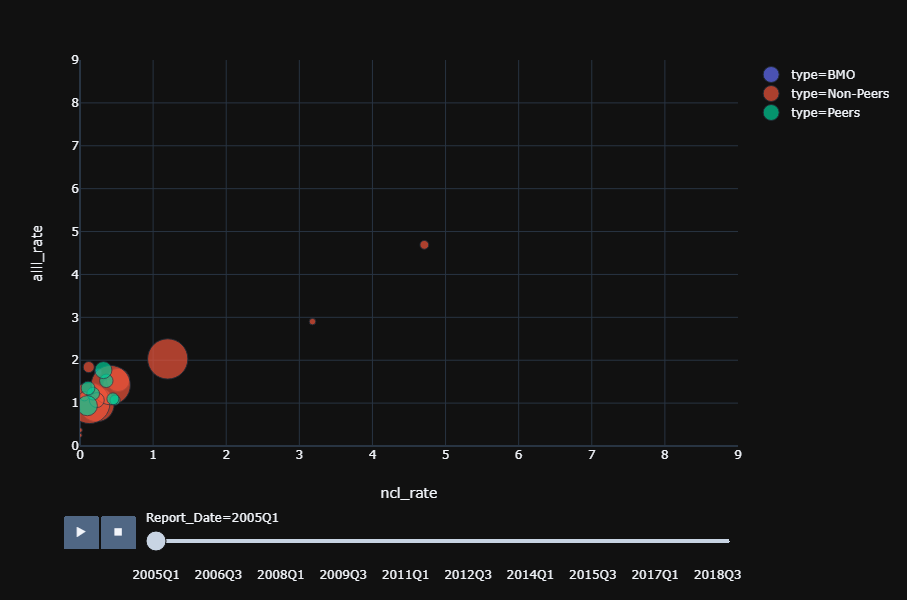

In [8]:
px.scatter(alll_mixA_agg, x="ncl_rate", y="alll_rate", animation_frame="Report_Date", 
           size="avg_os", color="type", hover_name="bank", size_max=45, range_x=[0, 9], range_y=[0, 9],template="plotly_dark")

In [5]:
alll_latest = alll_mixA_agg[alll_mixA_agg.Report_Date == '2018Q4'].sort_values(by=['type'])

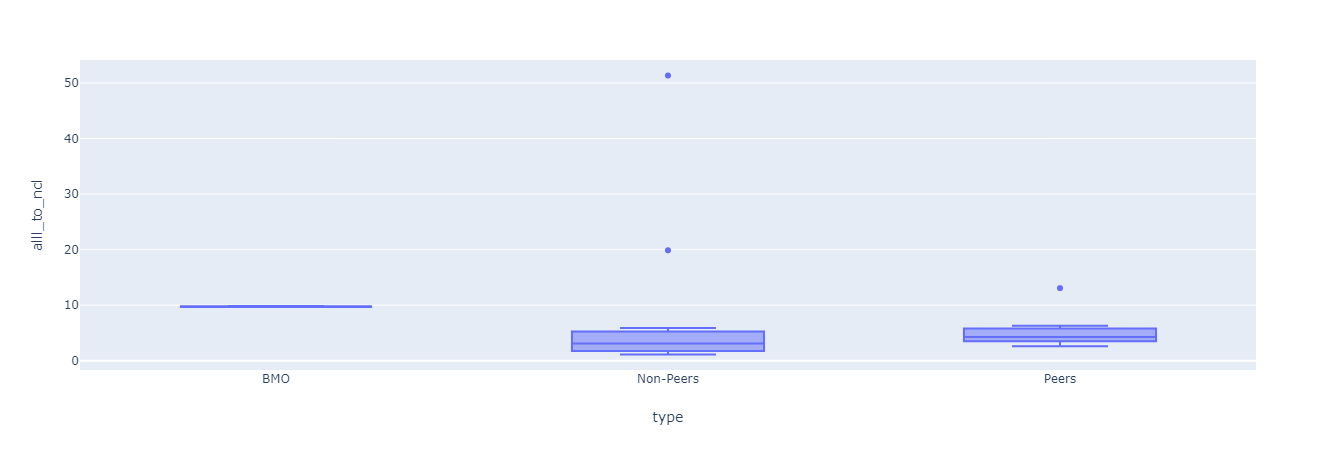

In [8]:
px.box(alll_latest, y="alll_to_ncl", x="type")

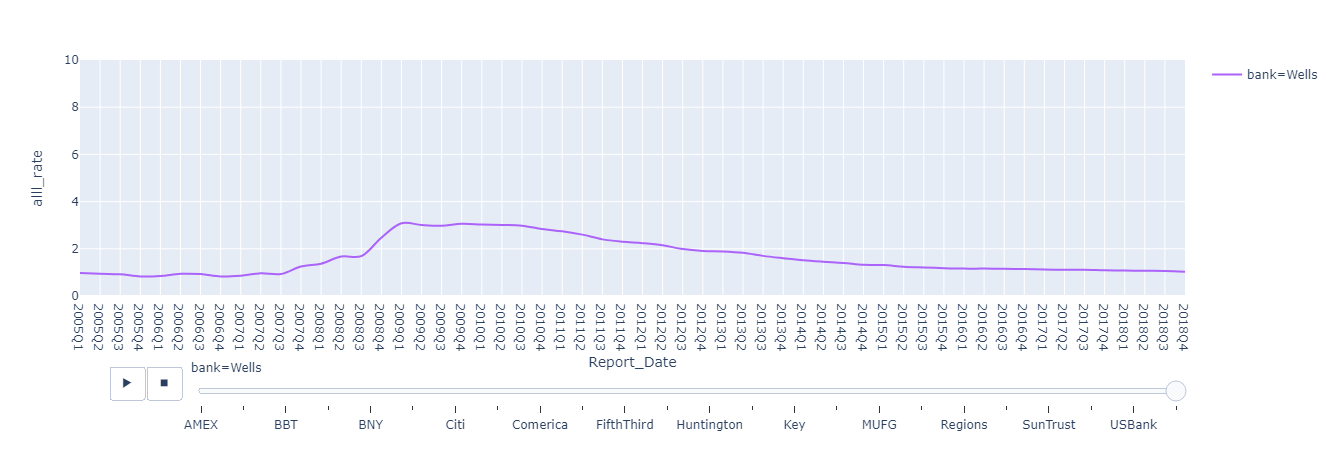

In [9]:
px.line(alll_mixA_agg, x="Report_Date", y="alll_rate", color="bank", hover_name="type", 
        animation_frame="bank", line_shape="spline", range_y=[0, 10])

In [10]:
tmp = alll_mixA_agg.groupby('bank').apply(lambda x: sum(x['alll_rate']*x['avg_os'])/sum(x['avg_os']))
alll_avg = pds.DataFrame(tmp, columns = ['alll_avg'])

tmp2 = alll_mixA_agg.groupby('bank')['alll_rate'].max()
alll_max = pds.DataFrame(tmp2).rename(columns = {'alll_rate':'alll_max'})

tmp3 = alll_mixA_agg.groupby('bank').apply(lambda x: x['Report_Date'][x['alll_rate']== x['alll_rate'].max()])
alll_maxqtr = pds.DataFrame(tmp3).rename(columns = {'Report_Date':'alll_maxqtr'})

In [11]:
alll_mix_summ = alll_avg.merge(alll_max, on='bank', how='inner').merge(alll_maxqtr, on='bank', how='inner')
alll_mix_summ['alll_peaktoavg'] = alll_mix_summ.alll_max / alll_mix_summ.alll_avg
alll_mix_summ['alll_avg'] = alll_mix_summ['alll_avg'].map('{:,.2f}'.format)
alll_mix_summ['alll_peaktoavg'] = alll_mix_summ['alll_peaktoavg'].map('{:,.2f}'.format)

alll_mix_summ[['alll_avg', 'alll_max', 'alll_peaktoavg']] = alll_mix_summ[['alll_avg', 'alll_max', 'alll_peaktoavg']] \
            .apply(pds.to_numeric)

In [12]:
cm = sns.light_palette("green", as_cmap=True)
alll_print = alll_mix_summ.style.background_gradient(cmap=cm, subset=['alll_max','alll_peaktoavg']) \
            .highlight_max(subset=['alll_max','alll_peaktoavg'])

alll_print

,alll_avg,alll_max,alll_maxqtr,alll_peaktoavg
bank,,,,
AMEX,3.17,9.31,2009Q3,2.94
BAC,1.77,3.62,2010Q2,2.04
BBT,1.35,2.53,2010Q2,1.88
BMO,1.43,3.34,2011Q2,2.33
BNY,0.93,2.22,2010Q1,2.4
CapOne,1.71,3.63,2009Q2,2.13
Citi,2.54,4.75,2009Q4,1.87
Citizens,1.49,2.46,2010Q1,1.65
Comerica,1.47,2.42,2010Q1,1.65
